 # Train file 
 ---
 For the model we will start by showing that we can purely train on depths 1 and 2 as those are the first instances containing every possible block

## Shift in the overall goal of this project:
---
Originally this project started with the goal to combine two networks together to create stereoscopic images based on surrealist art. However, this process, while definitely possible through sets of linear translations and object degmentation, is impractical for real runtime arguments. So here in the notebooks we provide a proof of concept for the network, however we will be turning this into a script for the Blender and Maxwell tools for 3-D modelling

Blender: Construct a 3D set of objects in a constrained 3-D domain
Maxwell: Render these objects

For now we will focus on a proof of concept ProGAN, and from there we repurpose this gan for our script.

In [1]:
### - imports - ###
from PIL import Image
import numpy as np
import glob
import cv2 as cv
import os
import random
import argparse
### - other data augmentation imports - ### (if needed)
### - Imports - ###
import math
import numpy as np
import sklearn as sk #general imports, initial data preprocessing/OS stuff
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os
import torch as T
import torch.nn as nn
import torch.optim as optim #Neural network imports, multiply data etc
from torchvision.transforms import ToTensor
import torchvision.models as models
import torchvision
import torch.nn.functional as F #Neural Network used in Comp4660 at ANU

from torch.autograd import Variable
from torch.optim.lr_scheduler import _LRScheduler

from sklearn.preprocessing import MinMaxScaler #normalize data
from sklearn.metrics import confusion_matrix #analysis
from torchvision import transforms
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset

from torchvision.datasets import ImageFolder
from NetworkMain import D, G
from tqdm import tqdm

Random Seed:  999


C:\Users\campb\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\campb\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
#This code will be added later when the file is converted to a python file
"""parser = argparse.ArgumentParser()
parser.add_argument('--root', type=str, default='./', help='directory contrains the data and outputs')
parser.add_argument('--epochs', type=int, default=40, help='training epoch number')
parser.add_argument('--out_res', type=int, default=128, help='The resolution of final output image')
parser.add_argument('--resume', type=int, default=0, help='continues from epoch number')
parser.add_argument('--cuda', action='store_true', help='Using GPU to train')


opt = parser.parse_args()"""

root = '/Users/campb/Documents/PersonalProjects/AGRNet/'
data_dir = root + 'Dataset/'
check_point_dir = root + 'check_points/'
output_dir = root + 'output/'
weight_dir = root+ 'weight/'
if not os.path.exists(check_point_dir):
	os.makedirs(check_point_dir)
if not os.path.exists(output_dir):
	os.makedirs(output_dir)
if not os.path.exists(weight_dir):
	os.makedirs(weight_dir)

In [3]:
### - Global Variables - ###
DFP = '/Users/campb/Documents/PersonalProjects/AGRNet/Dataset/Sample-'

img_folder = '/Users/campb/Documents/PersonalProjects/AGRNet/Dataset/'

NS = '/Sample-'

image_format = 'RGB'

schedule = [[5, 15, 25 ,35, 40],[3, 5, 5, 5, 4],[5, 5, 5, 1, 1]] #Epochs for each cycle num of epochs

batch_size = schedule[1][0]

growing = schedule[2][0]

epochs = 70

latent_size = 512

out_res = 1024

lr = 1e-5

lambd = 10

In [4]:
device = T.device('cuda:0' if (T.cuda.is_available())  else 'cpu')

transform = transforms.Compose([
            transforms.Resize(out_res),
            transforms.RandomCrop(out_res, 4),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
print(device)

cuda:0


In [5]:
#Create networks
Disc = None
Gen = None
Disc = D(latent_size, out_res).to(device)
Gen = G(latent_size, out_res).to(device)

In [6]:
#Noise for discriminator
fixed_noise = T.randn(16, latent_size, 1, 1).to(device)
#initialize optimizers
D_optimizer = optim.Adam(Disc.parameters(), lr=lr, betas=(0, 0.99))
G_optimizer = optim.Adam(Gen.parameters(), lr=lr, betas=(0, 0.99))
#Metric variables
D_running_loss = 0.0
G_running_loss = 0.0
iter_num = 0



In [7]:
#Load with ImageFolder wrapper
class ImageDataset(Dataset):
    def __init__(self,img_folder,names, transform):
        self.transform = transform
        self.image_names = names #Predetermined dataset
        self.img_folder=img_folder
        
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self,index):
        image=Image.open(self.img_folder+self.image_names[index]).convert("RGB")
        image=self.transform(image)
        return image

assert(os.path.exists(DFP + str(1) + ".jpg"))
rawimgf = sorted(glob.glob(DFP + '*.jpg', recursive = True))
### - image names - ###
imnames = [i.split('/')[-1].split("t")[-1][1:] for i in rawimgf]

### - Global data loader Vars - ###
norms = (0.5,0.5,0.5), (0.5,0.5,0.5)
train_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((out_res, out_res))])
# Parameters
params = {'batch_size': schedule[1][0],
          'shuffle': True,
         'num_workers': 0}

In [8]:
#Control variable
resume = 0
if resume != 0:
    check_point = T.load(check_point_dir+'check_point_epoch_%i.pth' % resume)
    fixed_noise = check_point['fixed_noise']
    G_net.load_state_dict(check_point['G_net'])
    D_net.load_state_dict(check_point['D_net'])
    G_optimizer.load_state_dict(check_point['G_optimizer'])
    D_optimizer.load_state_dict(check_point['D_optimizer'])
    G_epoch_losses = check_point['G_epoch_losses']
    D_epoch_losses = check_point['D_epoch_losses']
    G_net.depth = check_point['depth']
    D_net.depth = check_point['depth']
    G_net.alpha = check_point['alpha']
    D_net.alpha = check_point['alpha']




"""
except:
    print('Fully Grown\n')
    c = -1
    batch_size = schedule[1][c]
    growing = schedule[2][c]

    dataset = ImageDataset(img_folder,imnames, train_transform)
    data_loader = DataLoader(dataset, **params)

    tot_iter_num = (len(dataset)/batch_size)
    print(schedule[0][c], resume)

    if Gen.alpha < 1:
        Gen.fade_iters = (1-Gen.alpha)/(opt.epochs-opt.resume)/(2*tot_iter_num)
        Ddisc.fade_iters = (1-Disc.alpha)/(opt.epochs-opt.resume)/(2*tot_iter_num)"""


"\nexcept:\n    print('Fully Grown\n')\n    c = -1\n    batch_size = schedule[1][c]\n    growing = schedule[2][c]\n\n    dataset = ImageDataset(img_folder,imnames, train_transform)\n    data_loader = DataLoader(dataset, **params)\n\n    tot_iter_num = (len(dataset)/batch_size)\n    print(schedule[0][c], resume)\n\n    if Gen.alpha < 1:\n        Gen.fade_iters = (1-Gen.alpha)/(opt.epochs-opt.resume)/(2*tot_iter_num)\n        Ddisc.fade_iters = (1-Disc.alpha)/(opt.epochs-opt.resume)/(2*tot_iter_num)"

Training current depth 1 at size: 4 x 4


Size: 4.000 Epoch: 11.000 D_loss: 1.973   G_loss: 1.397: 100%|█████████████████████████| 12/12 [01:37<00:00,  8.10s/it]


Growing network to size: 8
Output Resolution: 8 x 8
Training current depth 2 at size: 8 x 8


Size: 8.000 Epoch: 13.000 D_loss: 0.771   G_loss: 0.924: 100%|█████████████████████████| 14/14 [02:51<00:00, 12.28s/it]


Growing network to size: 16
Output Resolution: 16 x 16
Training current depth 3 at size: 16 x 16


Size: 16.000 Epoch: 17.000 D_loss: 5.471   G_loss: 3.935: 100%|████████████████████████| 18/18 [05:04<00:00, 16.89s/it]


Growing network to size: 32
Output Resolution: 32 x 32
Training current depth 4 at size: 32 x 32


Size: 32.000 Epoch: 19.000 D_loss: 6.005   G_loss: 2.693: 100%|████████████████████████| 20/20 [09:57<00:00, 29.88s/it]


Growing network to size: 64
Output Resolution: 64 x 64
Training current depth 5 at size: 64 x 64


Size: 64.000 Epoch: 29.000 D_loss: 17.047   G_loss: 18.722: 100%|██████████████████████| 30/30 [39:04<00:00, 78.16s/it]


Growing network to size: 128
Output Resolution: 128 x 128
Training current depth 6 at size: 128 x 128


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 96.00 MiB (GPU 0; 4.00 GiB total capacity; 2.80 GiB already allocated; 0 bytes free; 2.91 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

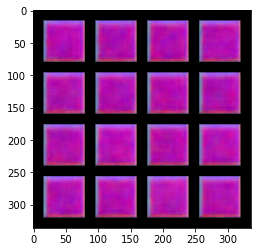

In [9]:
#Implement a different train loop that allows us to train the network on some data
#Depth -> Epochs -> samples for 9 total training cycles
schedule = [[12, 14, 18, 20, 30, 40, 52, 68, 82], #Epochs for each depth
            [12, 12, 6, 3, 3, 3, 2, 2, 2]] #Batch Size (Has to decrease to conserve memory)
dataset = ImageDataset(img_folder, imnames, train_transform)
# dataset = datasets.CelebA(data_dir, split='all', transform=transform)
data_loader = DataLoader(dataset, **params)

inc = 0
epoch_ = schedule[0][inc] #Increment 
batch_s_ = schedule[1][inc]
tot_iter_num = (len(dataset)/batch_size)
Gen.fade_iters = (1-Gen.alpha)/(schedule[0][inc])/(2*tot_iter_num)
Disc.fade_iters = (1-Disc.alpha)/(schedule[0][inc])/(2*tot_iter_num)

depth_losses_g = []
depth_losses_d = []

for depth in range(1, int(np.log2(out_res))):
    Gen.train()
    size = 2**(Gen.depth+1)
    print("Training current depth %d at size: %i x %i" % (depth, size, size))
    Depth_loss_g = 0.0
    Depth_loss_d = 0.0
    #Epochs
    epoch_ = schedule[0][inc] #save increment epoch and batch size
    batch_s_ = schedule[1][inc]
    D_epoch_losses = []
    G_epoch_losses = []
    databar = tqdm(range(epoch_))
    for epoch in databar:
        D_epoch_loss = 0.0
        G_epoch_loss = 0.0

        #databar = tqdm(data_loader)
        for i, samples in enumerate(data_loader):
            ##  update D
            if size != out_res: #Basically need to, A Reshape, B prepare the data for the networks
                samples = F.interpolate(samples, size=(size,size)).to(device)
            else:
                samples = samples.to(device)
            Disc.zero_grad()
            noise = T.randn(samples.size(0), latent_size, 1, 1, device=device)
            fake = Gen(noise)
            #out_grid = make_grid(fake, normalize=True, nrow=4, scale_each=True, padding=int(0.5*(2**Gen.depth))).permute(1,2,0)
            #plt.imshow(out_grid.cpu())
            fake_out = Disc(fake.detach())
            real_out = Disc(samples)
            ## Gradient Penalty

            eps = T.rand(samples.size(0), 1, 1, 1, device=device)
            eps = eps.expand_as(Gen(noise))
            x_hat = eps * samples + (1 - eps) * fake.detach()
            x_hat.requires_grad = True
            px_hat = Disc(x_hat)
            grad = T.autograd.grad(
                                        outputs = px_hat.sum(),
                                        inputs = x_hat, 
                                        create_graph=True
                                        )[0]
            grad_norm = grad.view(samples.size(0), -1).norm(2, dim=1)
            gradient_penalty = lambd * ((grad_norm  - 1)**2).mean()
            ###########

            D_loss = fake_out.mean() - real_out.mean() + gradient_penalty
            D_loss.backward()
            D_optimizer.step()

            ##	update G

            Gen.zero_grad()
            fake_out = Disc(fake)

            G_loss = - fake_out.mean()
            G_loss.backward()
            G_optimizer.step()

            ##############
            D_running_loss += abs(D_loss.item())
            G_running_loss += abs(G_loss.item())
            iter_num += 1
            if i % 3== 0:
                D_running_loss /= iter_num
                G_running_loss /= iter_num
                #print('iteration : %d, gp: %.2f' % (i, gradient_penalty))
                databar.set_description('Size: %0.3f Epoch: %.3f D_loss: %.3f   G_loss: %.3f' % (size, epoch, D_running_loss ,G_running_loss))
                iter_num = 0
                D_running_loss = 0.0
                G_running_loss = 0.0

        D_epoch_losses.append(D_epoch_loss/tot_iter_num)
        G_epoch_losses.append(G_epoch_loss/tot_iter_num)


        check_point = {'G_net' : Gen.state_dict(), 
                       'G_optimizer' : G_optimizer.state_dict(),
                       'D_net' : Disc.state_dict(),
                       'D_optimizer' : D_optimizer.state_dict(),
                       'D_epoch_losses' : D_epoch_losses,
                       'G_epoch_losses' : G_epoch_losses,
                       'fixed_noise': fixed_noise,
                       'depth': Gen.depth,
                       'alpha':Gen.alpha
                       }
        with T.no_grad():
            Gen.eval()
            T.save(check_point, check_point_dir + 'check_point_epoch_%d.pth' % (epoch))
            T.save(Gen.state_dict(), weight_dir + 'G_weight_epoch_%d.pth' %(epoch))
            out_imgs = Gen(fixed_noise).to(device)
            out_grid = make_grid(out_imgs, normalize=True, nrow=4, scale_each=True, padding=int(0.5*(2**Gen.depth))).permute(1,2,0)
            plt.imshow(out_grid.cpu())
            plt.savefig(output_dir + 'size_%i_epoch_%d' %(size ,epoch))
    depth_losses_g.append(np.mean(G_epoch_losses))
    depth_losses_d.append(np.mean(D_epoch_losses))
    #Increment depth step
    if 2**(Gen.depth+2) <= out_res:
        inc += 1
        print("Growing network to size: " + str(2**(Gen.depth+2)))
        data_loader = DataLoader(dataset, **params)
        tot_iter_num = tot_iter_num = (len(dataset)/batch_size)
        Gen.inc_depth(schedule[0][inc]*tot_iter_num)
        Disc.inc_depth(schedule[0][inc]*tot_iter_num)
        size = 2**(Gen.depth+1)
        print("Output Resolution: %d x %d" % (size, size))

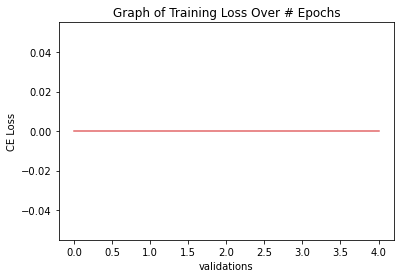

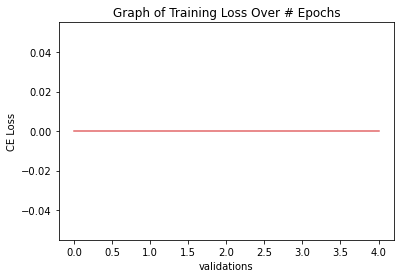

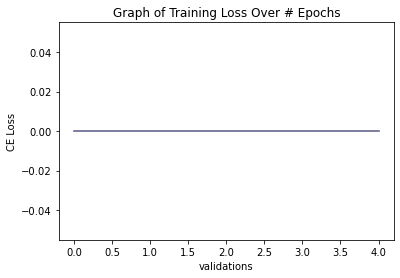

In [11]:
#Graph Depth losses (Mean epoch losses) Generator
plt.plot(range(0,5), depth_losses_g, alpha=0.7, color='tab:red')
plt.xlabel('validations')
plt.ylabel('CE Loss')
plt.title('Graph of Training Loss Over # Epochs')
plt.show()
#Graph Depth losses (Mean epoch losses) Discriminator
plt.plot(range(0,5), depth_losses_d, alpha=0.7, color='tab:red')
plt.xlabel('validations')
plt.ylabel('CE Loss')
plt.title('Graph of Training Loss Over # Epochs')
plt.show()
#Comparison graph
plt.plot(range(0,5), depth_losses_g, alpha=0.7, color='tab:red')
plt.plot(range(0,5), depth_losses_d, alpha=0.7, color='tab:blue')
plt.xlabel('validations')
plt.ylabel('CE Loss')
plt.title('Graph of Training Loss Over # Epochs')
plt.show()